In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import glob
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras import optimizers

In [ ]:
dir = 'refined_dataset'
listdir = os.listdir(dir)

print(listdir)
print("The number of dataset :", len(listdir))

['B05_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B48_discharge_soh.csv', 'B46_discharge_soh.csv', 'B34_discharge_soh.csv', 'B47_discharge_soh.csv', 'B07_discharge_soh.csv']
The number of dataset : 8


In [ ]:
num = ['B05', 'B07', 'B18', 'B33', 'B34', 'B46', 'B47', 'B48']
for i in range(len(listdir)):
    vector = np.zeros((1,3))
    path = os.path.join(os.getcwd(), 'refined_dataset/', num[i] + '_discharge_soh.csv')
    csv = pd.read_csv(path)
    df = pd.DataFrame(csv)
    
    vec = df[['cycle', 'capacity', 'SOH']]
    
    globals()['data_{}'.format(num[i])] = vec

In [ ]:
data = pd.read_csv('refined_dataset/B05_discharge_soh.csv')
df = pd.DataFrame(data)
df

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,capacity,cycle,SOH
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487,1,0.928244
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487,1,0.928244
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487,1,0.928244
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487,1,0.928244
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487,1,0.928244
...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312,1.325079,168,0.662540
50281,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062,1.325079,168,0.662540
50282,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828,1.325079,168,0.662540
50283,3.587336,0.001219,34.565580,0.0006,0.000,2810.640,1.325079,168,0.662540


In [ ]:
data_B05 

,cycle,capacity,SOH
0,1,1.856487,0.928244
1,1,1.856487,0.928244
2,1,1.856487,0.928244
3,1,1.856487,0.928244
4,1,1.856487,0.928244
...,...,...,...
50280,168,1.325079,0.662540
50281,168,1.325079,0.662540
50282,168,1.325079,0.662540
50283,168,1.325079,0.662540


In [ ]:
for i in range(len(listdir)):
    print("Shape of data :", np.shape(globals()['data_{}'.format(num[i])]))

Shape of data : (50285, 3)
Shape of data : (50285, 3)
Shape of data : (34866, 3)
Shape of data : (42200, 3)
Shape of data : (45909, 3)
Shape of data : (23478, 3)
Shape of data : (23478, 3)
Shape of data : (23478, 3)


In [ ]:
print(listdir)
dataset = data_B48["SOH"]
cycle = data_B48['cycle']

dataset = np.array(dataset)
dataset = dataset.reshape((len(dataset),1))
dataset.shape

['B05_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B48_discharge_soh.csv', 'B46_discharge_soh.csv', 'B34_discharge_soh.csv', 'B47_discharge_soh.csv', 'B07_discharge_soh.csv']


(23478, 1)

SPLIT TRAIN AND TEST DATA

In [ ]:
train_size = int(len(dataset) * 0.5)
# train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

11739 11739


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

11738
11738


In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(11738, 1, 1)
(11738, 1, 1)


TRAINING WITH LSTM

In [ ]:

model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2])))

model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(trainX, trainY, epochs=100, batch_size=20, validation_data=(testX, testY), verbose=1, shuffle = False)

Epoch 1/100
587/587 [==============================] - 9s 7ms/step - loss: 0.0613 - val_loss: 0.0087
Epoch 2/100
587/587 [==============================] - 5s 8ms/step - loss: 0.0041 - val_loss: 0.0087
Epoch 3/100
587/587 [==============================] - 3s 6ms/step - loss: 0.0041 - val_loss: 0.0084
Epoch 4/100
587/587 [==============================] - 3s 6ms/step - loss: 0.0036 - val_loss: 0.0084
Epoch 5/100
587/587 [==============================] - 5s 8ms/step - loss: 0.0039 - val_loss: 0.0083
Epoch 6/100
587/587 [==============================] - 3s 6ms/step - loss: 0.0037 - val_loss: 0.0083
Epoch 7/100
587/587 [==============================] - 4s 6ms/step - loss: 0.0044 - val_loss: 0.0082
Epoch 8/100
587/587 [==============================] - 7s 13ms/step - loss: 0.0039 - val_loss: 0.0084
Epoch 9/100
587/587 [==============================] - 6s 11ms/step - loss: 0.0037 - val_loss: 0.0084
Epoch 10/100
587/587 [==============================] - 5s 9ms/step - loss: 0.0043 - val_

In [ ]:
# save model architecture
model_json = model.to_json()
open('50%/model/B48_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('50%/model/B48_weights.h5', overwrite=True)

In [ ]:
# Load trained model
from keras.models import model_from_json 

json_file = open("70%/model/B48_model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
loaded_model.load_weights("70%/model/B48_weights.h5")
print("Loaded model from disk")

Loaded model from disk


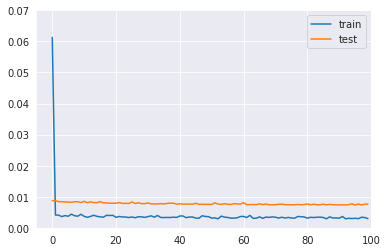

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.axis([-5, 100, 0, 0.07])
plt.legend() 
plt.show()

367/367 [==============================] - 1s 2ms/step


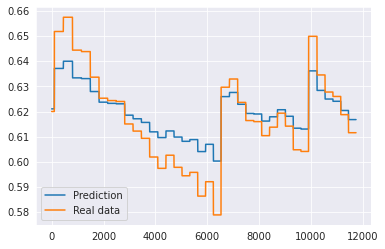

In [ ]:
yhat = model.predict(testX)
tyhat = model.predict(trainX)
plt.plot(yhat, label='Prediction')
plt.plot(testY, label='Real data')
plt.legend()
plt.show()

In [ ]:
print("Shape of train data :", trainX.shape)
print("Shape of prediction :", yhat.shape)
print("Shape of real data :", testY.shape)

Shape of train data : (11738, 1, 1)
Shape of prediction : (11738, 1)
Shape of real data : (11738,)


In [ ]:
rmse = math.sqrt(mean_squared_error(testY, yhat))
mae = mean_absolute_error(testY, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.009
Test MAE: 0.008


VISUALIZATION


In [ ]:
print("Shape of cycle :", np.shape(cycle))

cycle1 = cycle[0:train_size-1]
cycle2 = cycle[train_size+1:len(dataset)]

# cycle1 = cycle[0:train_size]
# cycle2 = cycle[train_size:len(dataset)]

print(np.shape(cycle1), np.shape(cycle2))

Shape of cycle : (23478,)
(11738,) (11738,)


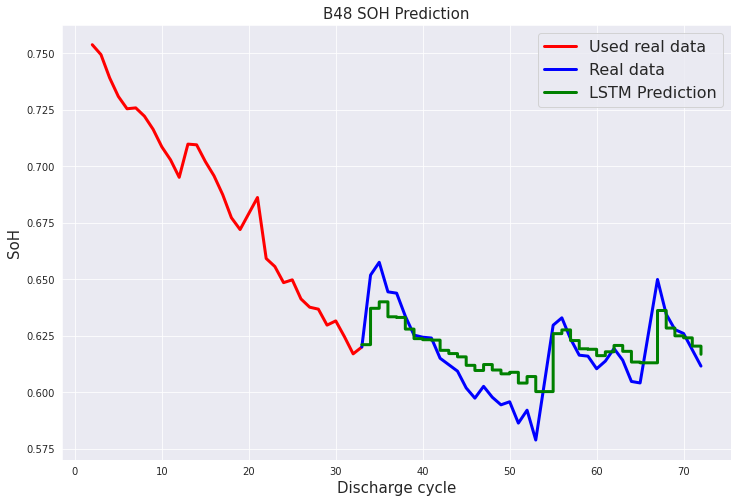

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))

plt.plot(cycle1, trainX[:,0],label='Used real data', linewidth = 3, color='r')
plt.plot(cycle2, testY,label='Real data', linewidth = 3, color='b')
# plt.plot(cycle2, yhat[:,0],label='LSTM Prediction', linewidth = 3, color='g')
plt.plot(cycle2, yhat[:,0],label='LSTM Prediction', linewidth = 3, color='g')
plt.legend(prop={'size': 16})

plt.ylabel('SoH', fontsize = 15)
plt.xlabel('Discharge cycle', fontsize = 15)
plt.title(str(num[7]) + " SOH Prediction", fontsize = 15)

plt.show()